In [4]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from joblib import Parallel, delayed

from matplotlib.colors import LinearSegmentedColormap

# Parula-like RGB list (approximate)
parula_data = [
    [0.2081, 0.1663, 0.5292],
    [0.2116, 0.1898, 0.5777],
    [0.2123, 0.2138, 0.6270],
    [0.2081, 0.2386, 0.6771],
    [0.1959, 0.2645, 0.7279],
    [0.1707, 0.2919, 0.7792],
    [0.1253, 0.3242, 0.8303],
    [0.0591, 0.3598, 0.8683],
    [0.0117, 0.3875, 0.8820],
    [0.0060, 0.4086, 0.8828],
    [0.0165, 0.4266, 0.8786],
    [0.0329, 0.4430, 0.8720],
    [0.0498, 0.4586, 0.8641],
    [0.0629, 0.4737, 0.8554],
    [0.0723, 0.4887, 0.8467],
    [0.0779, 0.5040, 0.8384],
    [0.0793, 0.5200, 0.8312],
    [0.0749, 0.5375, 0.8263],
    [0.0641, 0.5570, 0.8240],
    [0.0488, 0.5772, 0.8228],
    [0.0343, 0.5966, 0.8199],
    [0.0265, 0.6137, 0.8135],
    [0.0239, 0.6287, 0.8038],
    [0.0231, 0.6418, 0.7913],
    [0.0228, 0.6535, 0.7768],
    [0.0267, 0.6642, 0.7607],
    [0.0384, 0.6743, 0.7436],
    [0.0590, 0.6838, 0.7254],
    [0.0843, 0.6928, 0.7062],
    [0.1133, 0.7015, 0.6859],
    [0.1453, 0.7098, 0.6646],
    [0.1801, 0.7177, 0.6424],
    [0.2178, 0.7250, 0.6193],
    [0.2586, 0.7317, 0.5954],
    [0.3022, 0.7376, 0.5712],
    [0.3482, 0.7424, 0.5473],
    [0.3953, 0.7459, 0.5244],
    [0.4420, 0.7481, 0.5033],
    [0.4871, 0.7491, 0.4840],
    [0.5300, 0.7491, 0.4661],
    [0.5709, 0.7485, 0.4494],
    [0.6099, 0.7473, 0.4337],
    [0.6473, 0.7456, 0.4188],
    [0.6834, 0.7435, 0.4044],
    [0.7184, 0.7411, 0.3905],
    [0.7525, 0.7384, 0.3768],
    [0.7858, 0.7356, 0.3633],
    [0.8185, 0.7327, 0.3498],
    [0.8507, 0.7299, 0.3360],
    [0.8824, 0.7274, 0.3217],
    [0.9139, 0.7258, 0.3063],
    [0.9450, 0.7261, 0.2886],
    [0.9739, 0.7314, 0.2666],
    [0.9938, 0.7455, 0.2403],
    [0.9990, 0.7653, 0.2164],
    [0.9955, 0.7861, 0.1967],
    [0.9880, 0.8066, 0.1794],
    [0.9789, 0.8271, 0.1633],
    [0.9697, 0.8481, 0.1475],
    [0.9626, 0.8705, 0.1309],
    [0.9589, 0.8949, 0.1132],
    [0.9598, 0.9218, 0.0948],
    [0.9661, 0.9514, 0.0755],
]

# Create custom colormap
parula_map = LinearSegmentedColormap.from_list("parula", parula_data)




In [ ]:
###############################################################################
# System / Simulation Parameters
###############################################################################
N_t = 8       # number of Tx array elements
K   = 16       # number of OFDM subcarriers
M_x = 6       # number of RIS elements along x-axis
M_z = 6       # number of RIS elements along z-axis

beta = 1.0     # complex path gain (set to 1 for simplicity)

# Transmitter angles (degrees)
theta_T = 15
phi_T   = 10

# Communication user angles (degrees)
theta_c = 40
phi_c   = 30

# SNR setup (0 dB) - we’ll compute noise variance to match average signal power
SNR_dB  = 0
SNR_lin = 10 ** (SNR_dB / 10.0)
noiseVar = 1.0 / SNR_lin        # average QPSK symbol power = 1
noise_std = np.sqrt(noiseVar / K / 2.0)  # for complex noise


###############################################################################
# Define Helper Functions
###############################################################################
def array_factor(m, n, theta_deg, phi_deg):
    """
    Compute a_{mn}(\theta, phi) = exp( -j \pi [m sin(theta)*cos(phi) + n sin(theta)*sin(phi)] ).
    Angles are in degrees, so we convert to radians.
    """
    theta_rad = np.deg2rad(theta_deg)
    phi_rad   = np.deg2rad(phi_deg)
    return np.exp(-1j * np.pi * (m * np.sin(theta_rad) * np.cos(phi_rad)
                                 + n * np.sin(theta_rad) * np.sin(phi_rad)))

def normalized_sinc(x):
    """
    sinc: sinc(x) = sin(pi*x)/(pi*x).
    """
    if abs(x) < 1e-12:
        return 1.0
    else:
        return np.sin(np.pi * x) / (np.pi * x)

# c_{mn} = [ a_{mn}(\theta_c, phi_c) * a_{mn}(\theta_T, phi_T) ]^*
# We compute c_mat once, since it's independent of the "test" angle.
c_mat = np.zeros((M_x, M_z), dtype=complex)
for m in range(M_x):
    for n in range(M_z):
        temp = array_factor(m, n, theta_c, phi_c) * array_factor(m, n, theta_T, phi_T)
        c_mat[m, n] = np.conjugate(temp)  # unit-modulus

# obsolete function: use build_v instead
def get_v(theta_deg, phi_deg):
    """
    Returns the length-(2K-1) vector v. Indices: h in [-K+1, K-1].
    v_h = sum_{m=0}^{M_x-1} sum_{n=0}^{M_z-1} [
             a_{mn}(\theta_T, phi_T)*a_{mn}(\theta, phi)*c_{mn}*DeltaTau*sinc(...)*exp(...)
          ]
    """
    v_len = 2 * K - 1
    v_ = np.zeros(v_len, dtype=complex)
    
    for h_idx in range(v_len):
        # h goes from -K+1 to +K-1
        h = h_idx - (K - 1)
        sum_val = 0.0 + 0.0j
        for m in range(M_x):
            for n in range(M_z):
                a_tx = array_factor(m, n, theta_T, phi_T)
                a_rx = array_factor(m, n, theta_deg, phi_deg)
                c_   = c_mat[m, n]
                t0   = tau0_mat[m, n]
                
                # v_h includes the factor: DeltaTau * sinc(h*pi*DeltaTau)
                # * exp(-j*h*pi*(2*tau0 + DeltaTau)), etc.
                val_sinc  = normalized_sinc(h * delta_tau)
                val_phase = np.exp(-1j * h * np.pi * (2.0 * t0 + delta_tau))
                
                sum_val += a_tx * a_rx * c_ * delta_tau * val_sinc * val_phase
        v_[h_idx] = sum_val
    
    return v_


def build_toeplitz(v_):
    """
    Given v_ (length 2K-1), build the KxK Toeplitz matrix V.
    - First row = {v0, v_{-1}, ..., v_{-K+1}}
    - First col = {v0, v1, ..., v_{K-1}}
    Implementation detail:
      v_[K-1] = v_0
      row0 = v_[K-1::-1]  # reversed portion
      col0 = v_[K-1:   ]  # forward portion
    """
    # v_[K-1] corresponds to h = 0
    row0 = v_[K-1::-1]  # from h=0 down to h=-K+1
    col0 = v_[K-1:]     # from h=0 up to h=K-1
    return toeplitz(col0, row0)

###############################################################################
# QPSK Modulation / Demodulation
###############################################################################
# We use Gray-like labeling, but any consistent mapping works.
qpsk_map = np.array([
    (1+1j) / np.sqrt(2),
    (1-1j) / np.sqrt(2),
    (-1+1j) / np.sqrt(2),
    (-1-1j) / np.sqrt(2)
], dtype=complex)

def qpsk_demap(symbols):
    """
    Hard-decision QPSK demapper: finds the closest constellation point index
    for each symbol in 'symbols'.
    symbols shape = (K, Nsym).
    """
    const = qpsk_map.reshape((1, 4))  # shape (1, 4)
    # We'll return an array of indices in {0,1,2,3}
    out = np.zeros(symbols.shape, dtype=int)
    for col_idx in range(symbols.shape[1]):
        # shape => (K, 1) - (K, 4) => broadcast => get distances
        dist = np.abs(symbols[:, [col_idx]] - const)  # shape (K,4)
        out[:, col_idx] = np.argmin(dist, axis=1)
    return out


###############################################################################
# SER Computation for a Single (theta, phi)  // obsolete function, USE THE FOLLOWING compute_SER FUNCTION
###############################################################################
def compute_SER(theta_deg, phi_deg, Nsym=256):
    """
    1) Build Toeplitz matrix V for direction (theta, phi).
    2) Generate random QPSK symbols d.
    3) Compute received signal y = beta sqrt(N_t/K) V d + noise.
    4) Hard-decision demod, compare to transmitted data -> SER.
    """
    # Build the Toeplitz mixing matrix V
    v_ = get_v(theta_deg, phi_deg)
    V_ = build_toeplitz(v_)
    
    # Generate random QPSK symbols
    data_int = rnd.randint(0, 4, size=(K, Nsym))  # each entry in {0,1,2,3}
    d_ = qpsk_map[data_int]                       # map to complex points
    
    # Compute noise-free signal
    factor_ = np.sqrt(N_t / K)
    # y_noiseless shape => (K, Nsym)
    y_noiseless = beta * factor_ * (V_ @ d_)
    
    
    noise = noise_std * (rnd.randn(K, Nsym) + 1j * rnd.randn(K, Nsym))
    y_noisy = y_noiseless + noise
    
    # Hard-decision detection
    detected_int = qpsk_demap(y_noisy)
    
    # SER
    errors = np.sum(detected_int != data_int)
    SER_ = errors / (K * Nsym)
    return SER_




<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
/var/folders/rz/41zl2tzx7291w01vn14yfz0h0000gn/T/ipykernel_28196/3118697450.py:30: SyntaxWarning: invalid escape sequence '\p'
  """


In [6]:
def build_v(theta_deg, phi_deg, tau0_mat, delta_mat):
    """
    Build the length-(2K-1) vector v_ for user angles (theta_deg, phi_deg),
    using time-modulation params tau0_mat[m,n] in [0,1), delta_mat[m,n] in [0,1).
    """
    v_len = 2*K - 1
    v_ = np.zeros(v_len, dtype=complex)

    for h_idx in range(v_len):
        h = h_idx - (K - 1)  # h runs from -K+1 to +K-1
        sum_val = 0.0 + 0.0j
        for m in range(M_x):
            for n in range(M_z):
                a_tx = array_factor(m, n, theta_T, phi_T)   # a_{mn}(theta_T, phi_T)
                a_rx = array_factor(m, n, theta_deg, phi_deg)
                c_   = c_mat[m, n]
                t0   = tau0_mat[m, n]    # in [0,1)
                d_   = delta_mat[m, n]   # in [0,1)

                val_sinc  = normalized_sinc(h * d_)
                val_phase = np.exp(-1j * h * np.pi * (2.0 * t0 + d_))

                sum_val += a_tx * a_rx * c_ * d_ * val_sinc * val_phase
        v_[h_idx] = sum_val
    return v_

###############################################################################
# compute the objective C = sum_{j=0}^{K-1} log2(1 + SINR_j)
# SINR_j = [ (N_t/K)*|v0|^2 ] / [ (N_t/K)*( sum_{i=j-(K-1)}^j|v_i|^2 - |v0|^2 ) + noise_std^2 ]
# We'll interpret v_0 as the element h=0 => v_[K-1].
###############################################################################
def compute_objective(tau0_mat, delta_mat):
    """
    Returns the objective C for the given time-modulation parameters,
    at the user location (theta_c, phi_c).
    """
    # Build v_ for (theta_c, phi_c)
    v_ = build_v(theta_c, phi_c, tau0_mat, delta_mat)

    # We'll define "v_0" = v_[K-1].
    v_0 = v_[K-1]
    abs_v0_sq = np.abs(v_0)**2

    # For each subcarrier j in [0..K-1], define the index range [j-(K-1), j].
    # We'll sum |v_i|^2 for i in that range, but we have to shift for indexing
    # because v_ goes from h=-K+1 to h=K-1 => h_idx=0..(2K-2).
    # So h_idx = h + (K-1).
    C_val = 0.0

    for j in range(K):
        # The range is i from j-(K-1) to j
        # We'll build those h values:
        h_min = j - (K-1)  # might be negative
        h_max = j

        # convert them to indices in v_
        # h_idx = h + (K-1)
        # so we want all h_idx from h_min+(K-1) to h_max+(K-1)
        idx_min = h_min + (K-1)
        idx_max = h_max + (K-1)

        # sum of squares from idx_min..idx_max
        subset = v_[idx_min : idx_max+1]  # because slice is up to idx_max+1
        sum_sq = np.sum(np.abs(subset)**2)

        # The formula says subtract |v0|^2
        # => total side-lobe: sum_sq - abs_v0_sq
        # Then multiply by (N_t/K)
        denom = (N_t/K)*(sum_sq - abs_v0_sq) + noise_std**2

        num = (N_t/K)*abs_v0_sq
        sinr_j = num / denom

        C_val += np.log2(1.0 + sinr_j)

    return C_val

In [7]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm

# Q_num = M_x*M_z
Q_num = 8
input_num = 2*M_x*M_z*Q_num
output_num = 4*M_x*M_z*Q_num
trajectory_num = 2*M_x*M_z

def build_mask(x, Mx, Mz, Q):
    """
    x: A 1D PyTorch tensor of shape (2 * Mx * Mz * Q,), containing {0,1}.
       - x[i] = 1 means the i-th discrete value is selected
                for some tau or delta element.
       - x[i] = 0 means not selected.

    Mx, Mz: Dimensions of the RIS (e.g., M_x x M_z).
    Q: Number of discrete values for each parameter.

    Returns:
        mask: A 1D tensor of the same shape as x, with {0,1} entries.
              - mask[i] = 0 => that action is disallowed
              - mask[i] = 1 => that action is allowed
    """

    # Create an all-ones mask to start (allow everything by default)
    mask = torch.ones_like(x)

    # Total number of blocks = 2*Mx*Mz (since we have tau and delta)
    num_blocks = 2 * Mx * Mz

    # Iterate over each block of size Q
    for p in range(num_blocks):
        block_start = p * Q
        block_end   = (p + 1) * Q

        # Count how many bits are set in this block
        block_sum = x[block_start:block_end].sum()

        # If any bit in this block is already 1, the block is "complete"
        if block_sum > 0.5:
            # Disallow any further selection in this block
            mask[block_start:block_end] = 0.0
        else:
            # If sum == 0, the block is not chosen yet, so keep it open (all 1)
            pass  # (mask remains 1.0 for that block)

    return mask



class TBModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    
    self.mlp = nn.Sequential(
      nn.Linear(input_num, num_hid), 
      nn.ReLU(),
      nn.Linear(num_hid, num_hid), 
      nn.ReLU(),
      nn.Linear(num_hid, num_hid), 
      nn.ReLU(),
      # We now output 'output_num' numbers, half for P_F and half for P_B
      nn.Linear(num_hid, output_num)
      )
    # log Z is a learnable variable
    self.logZ = nn.Parameter(torch.ones(1))
    

  def forward(self, x):
    logits = self.mlp(x)
    
    # Build the mask for forward actions
    mask_F = build_mask(x, Mx = M_x, Mz = M_z, Q = Q_num)
    
    # Slice the logits, and mask invalid actions (since we're predicting
    # log-values), we use -100 since exp(-100) is tiny, but we don't want -inf)
    # P_F = logits[..., :6] * (1 - x) + x * -100
    P_F = logits[..., :input_num] * mask_F + (1-mask_F) * -100
    P_B = logits[..., input_num:] * x + (1 - x) * -100
    return P_F, P_B

In [8]:
def transform_state_to_time_mats(x):
    """
    x: 1D NumPy array (or PyTorch tensor) of shape (2 * Mx * Mz * Q,) with values in {0,1}.
       At terminal state, each block of Q bits has exactly one bit = 1.

    Mx, Mz: Dimensions of RIS (Mx x Mz).
    Q: Number of discrete values for tau0/delta in [0, 1).

    Returns:
        tau0_mat: (Mx, Mz) array, each entry in {0, 1/Q, 2/Q, ..., (Q-1)/Q}.
        delta_mat: (Mx, Mz) array, same discrete set.
    """

    # Initialize outputs
    tau0_mat = np.zeros((M_x, M_z), dtype=float)
    delta_mat = np.zeros((M_x, M_z), dtype=float)

    # 1) Reconstruct tau0_mat
    #    Blocks 0..(Mx*Mz-1) are tau0 blocks, each block has Q bits.
    #    For block p, the offset in x is [p*Q : (p+1)*Q].
    #    Then we find which index in that block is 1 => that index / Q is the chosen fraction.
    for p in range(M_x * M_z):
        # Indices for block p
        block_start = p * Q_num
        block_end   = (p + 1) * Q_num

        # Find which bit is 1
        block_slice = x[block_start:block_end]
        chosen_idx = np.argmax(block_slice)  # which index in [0..Q-1] is 1

        # Convert block index p => (m, n)
        m = p // M_z
        n = p % M_z

        # Assign tau0 in [0, 1) via chosen_idx / Q
        tau0_mat[m, n] = chosen_idx / Q_num

    # 2) Reconstruct delta_mat
    #    Blocks (Mx*Mz) .. (2*Mx*Mz - 1) correspond to delta
    #    block p' = p + Mx*Mz
    #    offset = p'*Q => [p'*Q : (p'+1)*Q]
    for p in range(M_x * M_z):
        block_idx = p + (M_x * M_z)  # offset block for delta
        block_start = block_idx * Q_num
        block_end   = (block_idx + 1) * Q_num

        block_slice = x[block_start:block_end]
        chosen_idx = np.argmax(block_slice)

        m = p // M_z
        n = p % M_z
        delta_mat[m, n] = chosen_idx / Q_num

    return tau0_mat, delta_mat


100%|█████████████████████████████████████████████████████| 400000/400000 [8:35:30<00:00, 12.93it/s]


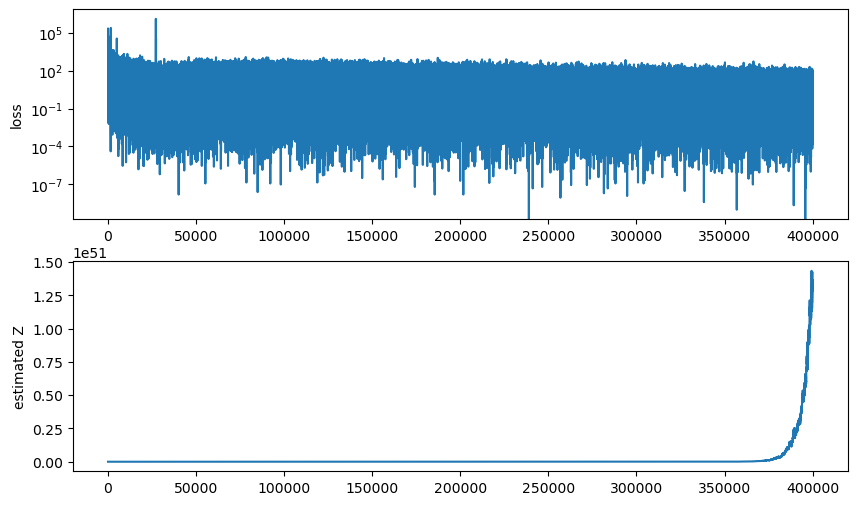

In [ ]:
# Instantiate model and optimizer
model = TBModel(256)
opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses and the TM configuration we sample
tb_losses = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 1

logZs = []
for episode in tqdm.tqdm(range(400000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32)
  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = 0
  total_P_B = 0
  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action.item()] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      # If we've built a complete TM-IRS, we're done, so the reward is > 0
      # (unless the TM is incomplete)
      tau0_mat, delta_mat = transform_state_to_time_mats(new_state)
      reward = torch.tensor(compute_objective(tau0_mat, delta_mat)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, then compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss

  # If we are at an update episode, take a gradient step.
  if episode % update_freq == 0:
    tb_losses.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    logZs.append(model.logZ.item())


# When saving, use other namse to avoid overriding the original saved model!!!
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': opt.state_dict(),
#     'losses': tb_losses,
#     'logZs': logZs
# }, "tb_checkpoint.pth")


f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs))
plt.ylabel('estimated Z');

100%|█████████████████████████████████████████████████████████| 20000/20000 [27:34<00:00, 12.09it/s]


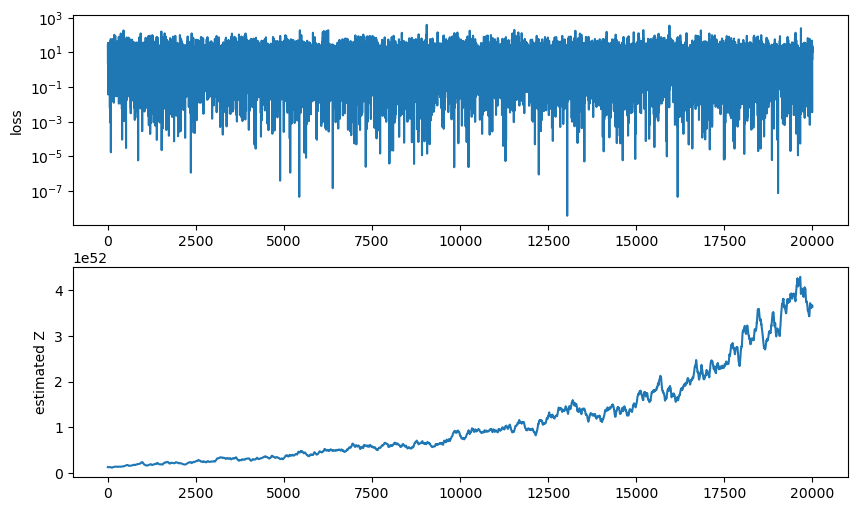

In [ ]:
# optimizer
opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses
tb_losses_1 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 1

logZs_1 = []
for episode in tqdm.tqdm(range(20000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32)
  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = 0
  total_P_B = 0
  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action.item()] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      # If we've built a complete TM-IRS, we're done, so the reward is > 0
      # (unless the TM is incomplete)
      tau0_mat, delta_mat = transform_state_to_time_mats(new_state)
      reward = torch.tensor(compute_objective(tau0_mat, delta_mat)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, let's compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss

  # If we are at an update episode, take a gradient step.
  if episode % update_freq == 0:
    tb_losses_1.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    logZs_1.append(model.logZ.item())



f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_1)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_1))
plt.ylabel('estimated Z');

100%|███████████████████████████████████████████████████████| 50000/50000 [1:10:47<00:00, 11.77it/s]


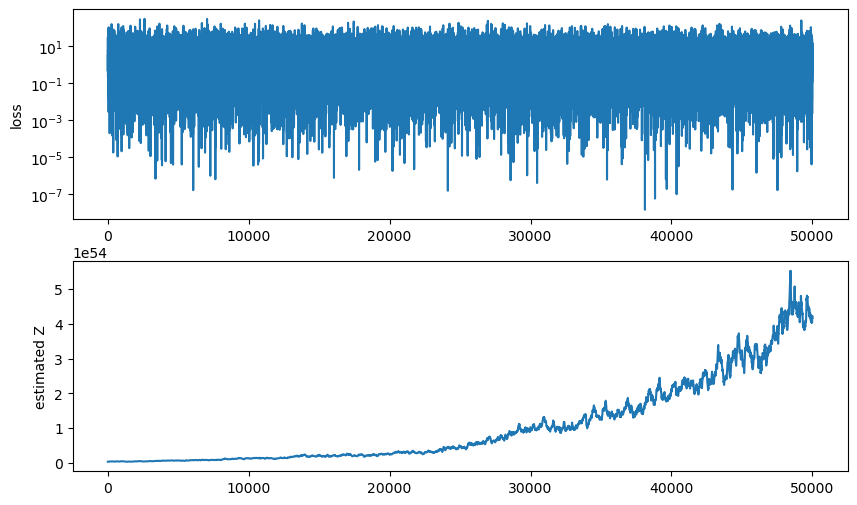

In [ ]:
# optimizer
opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses
tb_losses_2 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 1

logZs_2 = []
for episode in tqdm.tqdm(range(50000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32)
  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = 0
  total_P_B = 0
  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action.item()] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      tau0_mat, delta_mat = transform_state_to_time_mats(new_state)
      reward = torch.tensor(compute_objective(tau0_mat, delta_mat)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, let's compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss

  if episode % update_freq == 0:
    tb_losses_2.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    logZs_2.append(model.logZ.item())



f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_2)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_2))
plt.ylabel('estimated Z');

100%|███████████████████████████████████████████████████████| 50000/50000 [1:08:43<00:00, 12.13it/s]


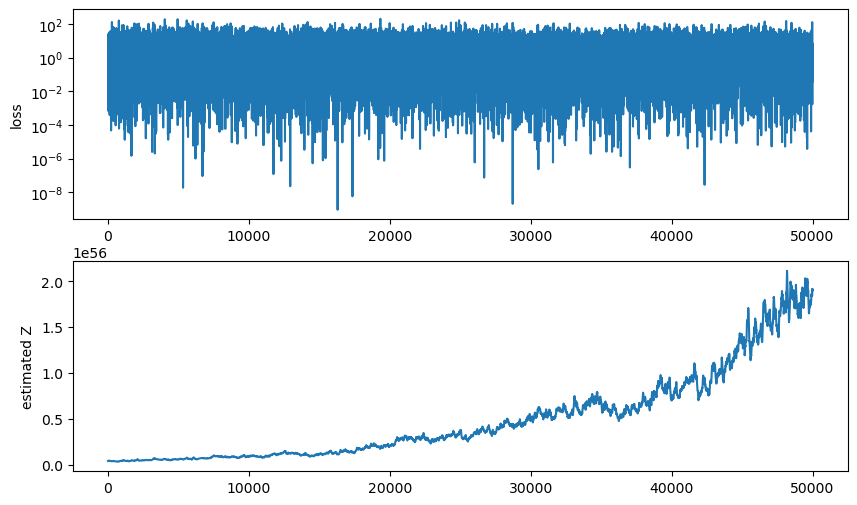

In [ ]:
# optimizer
opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses
tb_losses_3 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 1

logZs_3 = []
for episode in tqdm.tqdm(range(50000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32)
  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = 0
  total_P_B = 0
  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action.item()] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      tau0_mat, delta_mat = transform_state_to_time_mats(new_state)
      reward = torch.tensor(compute_objective(tau0_mat, delta_mat)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, let's compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss

  if episode % update_freq == 0:
    tb_losses_3.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    logZs_3.append(model.logZ.item())



f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_3)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_3))
plt.ylabel('estimated Z');

100%|█████████████████████████████████████████████████████| 100000/100000 [2:17:41<00:00, 12.10it/s]


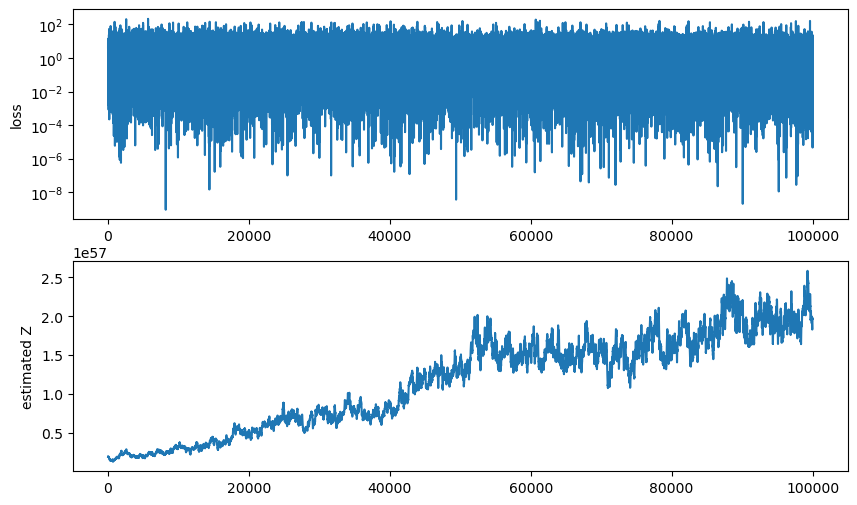

In [ ]:
# optimizer
opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses
tb_losses_4 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 1

logZs_4 = []
for episode in tqdm.tqdm(range(100000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32)
  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = 0
  total_P_B = 0
  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action.item()] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      tau0_mat, delta_mat = transform_state_to_time_mats(new_state)
      reward = torch.tensor(compute_objective(tau0_mat, delta_mat)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, let's compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss

  if episode % update_freq == 0:
    tb_losses_4.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    logZs_4.append(model.logZ.item())



f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_4)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_4))
plt.ylabel('estimated Z');

100%|███████████████████████████████████████████████████████| 50000/50000 [1:09:08<00:00, 12.05it/s]


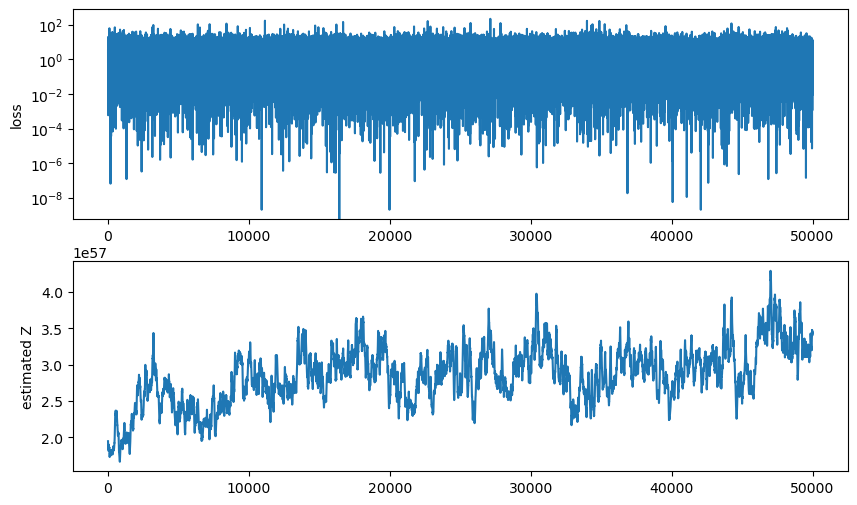

In [ ]:
# optimizer
opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses
tb_losses_5 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 1

logZs_5 = []
for episode in tqdm.tqdm(range(50000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32)
  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = 0
  total_P_B = 0
  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action.item()] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      tau0_mat, delta_mat = transform_state_to_time_mats(new_state)
      reward = torch.tensor(compute_objective(tau0_mat, delta_mat)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, let's compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss

  if episode % update_freq == 0:
    tb_losses_5.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    logZs_5.append(model.logZ.item())



f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_5)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_5))
plt.ylabel('estimated Z');

100%|█████████████████████████████████████████████████████████| 30000/30000 [40:54<00:00, 12.22it/s]


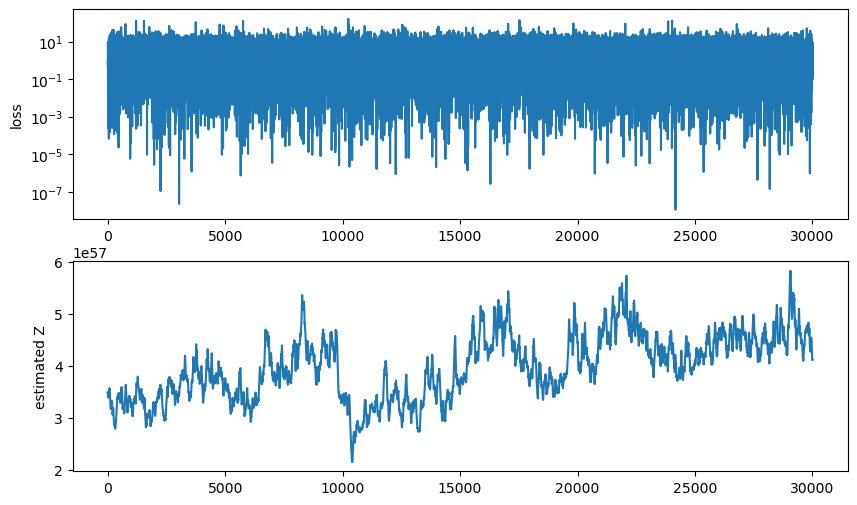

In [ ]:
# optimizer
opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses
tb_losses_6 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 1

logZs_6 = []
for episode in tqdm.tqdm(range(30000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32)
  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = 0
  total_P_B = 0
  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action.item()] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      tau0_mat, delta_mat = transform_state_to_time_mats(new_state)
      reward = torch.tensor(compute_objective(tau0_mat, delta_mat)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, let's compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss

  if episode % update_freq == 0:
    tb_losses_6.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    logZs_6.append(model.logZ.item())



f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_6)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_6))
plt.ylabel('estimated Z');

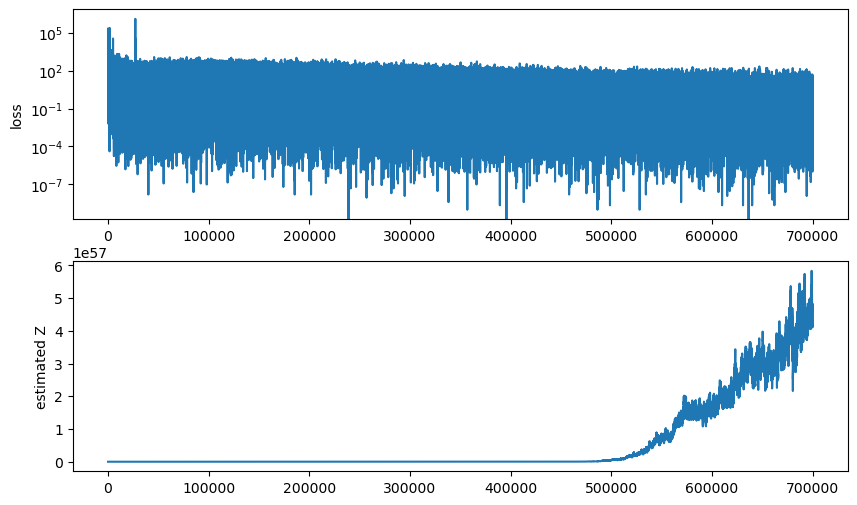

In [14]:
all_losses = np.concatenate([
    tb_losses,
    tb_losses_1,
    tb_losses_2,
    tb_losses_3,
    tb_losses_4,
    tb_losses_5,
    tb_losses_6
])

all_logZs = np.concatenate([
    logZs,
    logZs_1,
    logZs_2,
    logZs_3,
    logZs_4,
    logZs_5,
    logZs_6
])

f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(all_losses)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(all_logZs))
plt.ylabel('estimated Z');

100%|█████████████████████████████████████████████████████| 100000/100000 [2:12:30<00:00, 12.58it/s]


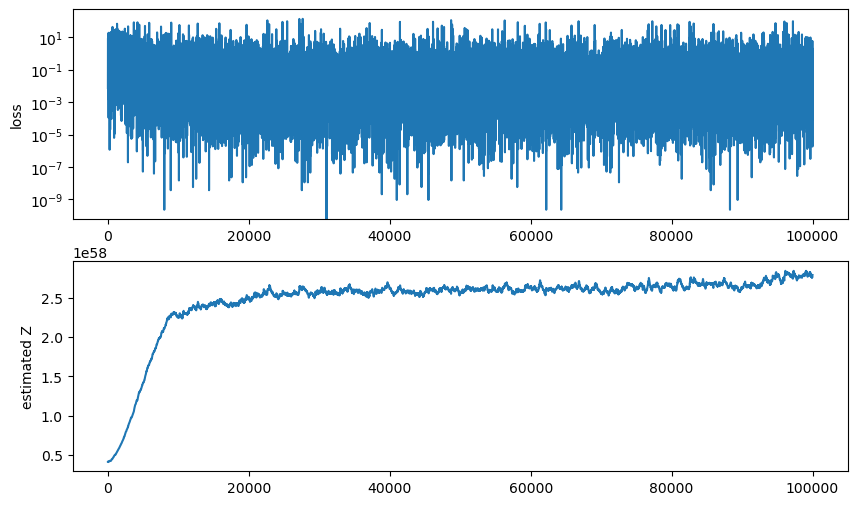

In [ ]:
# optimizer
opt = torch.optim.Adam(model.parameters(),  1e-3)

# Let's keep track of the losses
tb_losses_7 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 1

logZs_7 = []
for episode in tqdm.tqdm(range(100000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32)
  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = 0
  total_P_B = 0
  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action.item()] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      tau0_mat, delta_mat = transform_state_to_time_mats(new_state)
      reward = torch.tensor(compute_objective(tau0_mat, delta_mat)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, let's compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss

  if episode % update_freq == 0:
    tb_losses_7.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    logZs_7.append(model.logZ.item())



f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_7)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_7))
plt.ylabel('estimated Z');

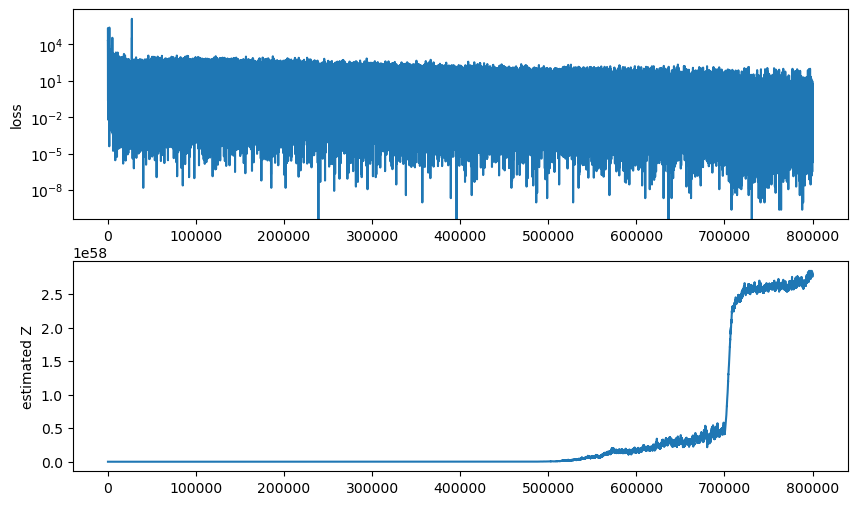

In [17]:
all_losses = np.concatenate([
    tb_losses,
    tb_losses_1,
    tb_losses_2,
    tb_losses_3,
    tb_losses_4,
    tb_losses_5,
    tb_losses_6,
    tb_losses_7
])

all_logZs = np.concatenate([
    logZs,
    logZs_1,
    logZs_2,
    logZs_3,
    logZs_4,
    logZs_5,
    logZs_6,
    logZs_7
])

f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(all_losses)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(all_logZs))
plt.ylabel('estimated Z');

100%|█████████████████████████████████████████████████████| 100000/100000 [2:17:20<00:00, 12.14it/s]


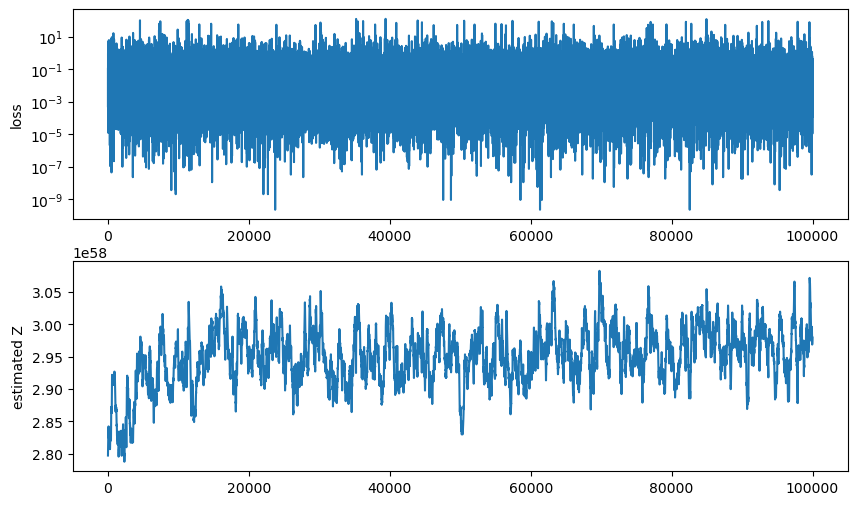

In [ ]:
# optimizer
opt = torch.optim.Adam(model.parameters(),  1e-3)

# Let's keep track of the losses
tb_losses_8 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 1

logZs_8 = []
for episode in tqdm.tqdm(range(100000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32)
  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = 0
  total_P_B = 0
  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action.item()] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      tau0_mat, delta_mat = transform_state_to_time_mats(new_state)
      reward = torch.tensor(compute_objective(tau0_mat, delta_mat)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, let's compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss

  if episode % update_freq == 0:
    tb_losses_8.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    logZs_8.append(model.logZ.item())



f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_8)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_8))
plt.ylabel('estimated Z');

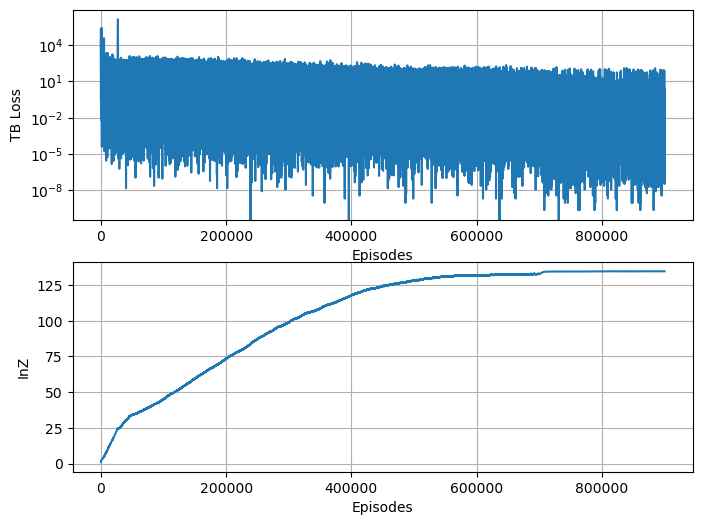

In [87]:
all_losses = np.concatenate([
    tb_losses,
    tb_losses_1,
    tb_losses_2,
    tb_losses_3,
    tb_losses_4,
    tb_losses_5,
    tb_losses_6,
    tb_losses_7,
    tb_losses_8
])

all_logZs = np.concatenate([
    logZs,
    logZs_1,
    logZs_2,
    logZs_3,
    logZs_4,
    logZs_5,
    logZs_6,
    logZs_7,
    logZs_8
])

f, ax = plt.subplots(2, 1, figsize=(8,6))
plt.grid(True)
plt.sca(ax[0])
plt.plot(all_losses)
plt.yscale('log')
plt.xlabel('Episodes')
plt.ylabel('TB Loss')
plt.grid(True)
plt.sca(ax[1])
plt.plot((all_logZs))
plt.xlabel('Episodes')
plt.ylabel('InZ');
plt.savefig('f1.eps', format='eps', bbox_inches='tight')

In [ ]:
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': opt.state_dict(),
#     'losses': all_losses,
#     'logZs': all_logZs
# }, "tb_checkpoint (1).pth")

/var/folders/rz/41zl2tzx7291w01vn14yfz0h0000gn/T/ipykernel_28196/440306894.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


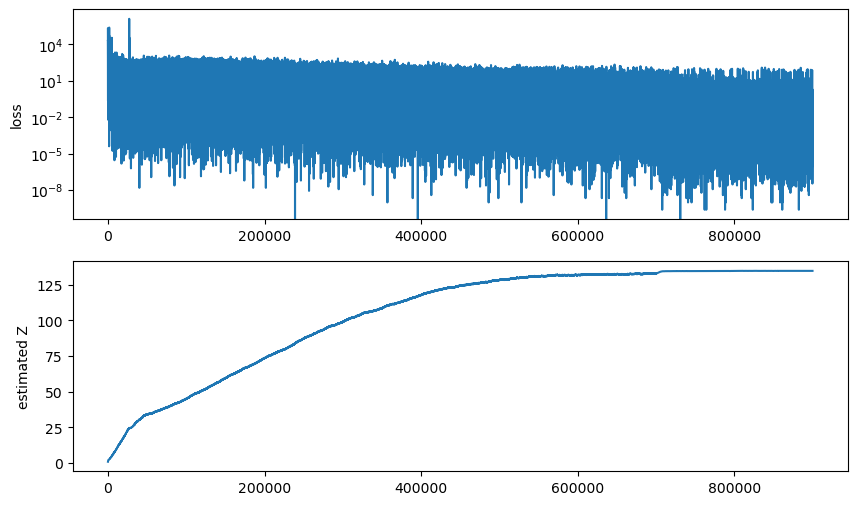

In [9]:
# import torch
# import matplotlib.pyplot as plt
checkpoint_path = "tb_checkpoint_0dB.pth"
checkpoint = torch.load(checkpoint_path)
tb_losses_5 = checkpoint['losses']
logZs_5 = checkpoint['logZs']

f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_5)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(logZs_5)
plt.ylabel('estimated Z');


# Instantiate model and optimizer
model = TBModel(256)
opt = torch.optim.Adam(model.parameters(),  1e-3)
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])

In [10]:
def compute_SER(theta_deg, phi_deg, tau0_mat, delta_mat, Nsym=200):
    # Build the Toeplitz mixing matrix V
    v_ = build_v(theta_deg, phi_deg, tau0_mat, delta_mat)
    V_ = build_toeplitz(v_)

    # Generate random QPSK symbols
    data_int = rnd.randint(0, 4, size=(K, Nsym))  # each entry in {0,1,2,3}
    d_ = qpsk_map[data_int]                       # map to complex points

    # Compute noise-free signal
    factor_ = np.sqrt(N_t / K)
    # y_noiseless shape => (K, Nsym)
    y_noiseless = beta * factor_ * (V_ @ d_)

    # 
    noise = noise_std * (rnd.randn(K, Nsym) + 1j * rnd.randn(K, Nsym))
    y_noisy = y_noiseless + noise

    # Hard-decision detection
    detected_int = qpsk_demap(y_noisy)

    # SER
    errors = np.sum(detected_int != data_int)
    SER_ = errors / (K * Nsym)
    return SER_

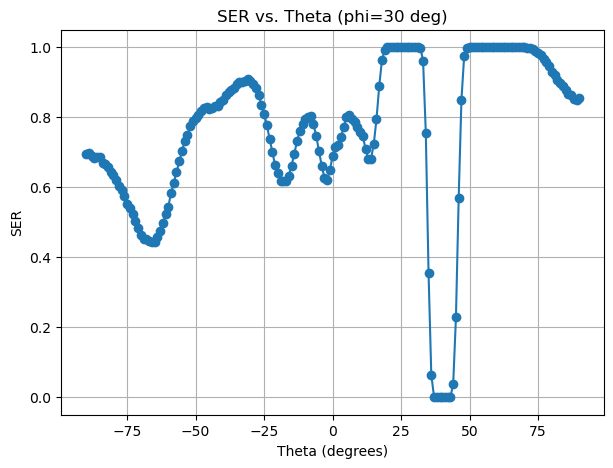

In [15]:
# Each episode starts with an "empty state"
state = torch.zeros(input_num, dtype=torch.float32)
# Predict P_F, P_B
P_F_s, P_B_s = model(state)

for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    
    # action = torch.argmax(P_F_s)
    
    # "Go" to the next state
    new_state = state.clone()
    new_state[action.item()] = 1.0

    P_F_s, P_B_s = model(new_state)
    # Continue iterating
    state = new_state
    
best_tau0, best_delta = transform_state_to_time_mats(state)

# Step 2: Now fix best_tau0, best_delta, and do SER vs. theta in [90..-90]
phi_fixed = 30
theta_list = np.arange(-90, 91, 1)
SER_vals = np.zeros(len(theta_list))

# for i, th in enumerate(theta_list):
#     SER_vals[i] = compute_SER(th, phi_fixed, best_tau0, best_delta, Nsym=1024)
            

SER_vals = Parallel(n_jobs=-1)(
    delayed(compute_SER)(th, phi_fixed, best_tau0, best_delta, Nsym=1024)
    for th in theta_list
    )
    
SER_vals = np.array(SER_vals)

# Note to use different file name to avoid overriding
# filename = 'results_data4.npz'
# np.savez(filename, best_tau0=best_tau0, best_delta=best_delta, SER_vals=SER_vals)
    
# Step 3: Plot the result
plt.figure(figsize=(7,5))
plt.plot(theta_list, SER_vals, 'o-')
plt.grid(True)
plt.xlabel("Theta (degrees)")
plt.ylabel("SER")
plt.title(f"SER vs. Theta (phi={phi_fixed} deg)")
plt.show()




Computing SER on a grid of size 181 x 181 ...


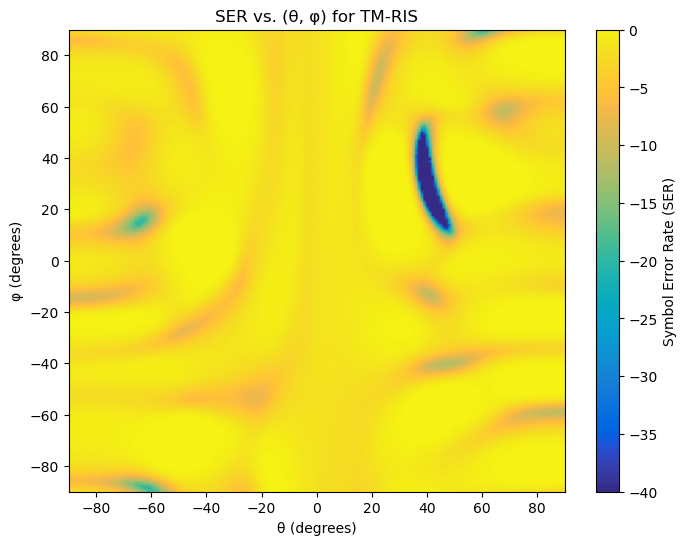

In [17]:
# Grid for scanning directions (theta, phi)
theta_step = 1
phi_step   = 1
theta_list = np.arange(-90, 91, theta_step)  # theta amzimuth angle
phi_list   = np.arange(90, -91, -phi_step)     # phi elevation angle

theta_len = len(theta_list)
phi_len   = len(phi_list)

# Prepare a 2D array for SER results
SER_map = np.zeros((phi_len, theta_len))

print("Computing SER on a grid of size {} x {} ...".format(theta_len, phi_len))

# parallel process
SER_map = Parallel(n_jobs=-1)(   # use all available cores
    delayed(compute_SER)(th, ph, best_tau0, best_delta, Nsym=256)
    for ph in phi_list
    for th in theta_list
)

# Then reshape SER_map to 2D
SER_map = np.array(SER_map).reshape(phi_len, theta_len)
SER_map = 10 * np.log10(SER_map + 1e-4)


# data = np.load(filename)
# updated_data = dict(data)
# updated_data['SER_map'] = SER_map
# np.savez(filename, **updated_data)

###############################################################################
# Plot the 2D Heatmap: SER vs. (theta, phi)
###############################################################################
plt.figure(figsize=(8, 6))

# By default, imshow will map array row 0 to the top. Our row 0 corresponds to theta=90 deg.
# We'll show phi along the x-axis, and theta along the y-axis (top=+90, bottom=-90).
# extent => [x_min, x_max, y_min, y_max], and we set origin='upper' to match indexing.
plt.imshow(
    SER_map,
    origin='upper',
    extent=[theta_list[0], theta_list[-1], phi_list[-1], phi_list[0]],
    aspect='auto',
    cmap=parula_map
)

plt.colorbar(label='Symbol Error Rate (SER)')
plt.title('SER vs. (θ, φ) for TM-RIS')
plt.xlabel('θ (degrees)')
plt.ylabel('φ (degrees)')
plt.show()


In [18]:
print(best_tau0)


[[0.25  0.625 0.125 0.5   0.25  0.5  ]
 [0.875 0.875 0.75  0.25  0.75  0.   ]
 [0.75  0.375 0.25  0.125 0.625 0.75 ]
 [0.5   0.875 0.75  0.25  0.875 0.   ]
 [0.    0.25  0.75  0.625 0.625 0.5  ]
 [0.25  0.75  0.5   0.625 0.25  0.375]]


In [19]:
print(best_delta)


[[0.375 0.75  0.375 0.5   0.625 0.125]
 [0.375 0.5   0.    0.875 0.25  0.875]
 [0.25  0.25  0.875 0.125 0.125 0.75 ]
 [0.625 0.125 0.125 0.75  0.375 0.25 ]
 [0.75  0.75  0.25  0.25  0.25  0.5  ]
 [0.125 0.5   0.875 0.25  0.875 0.   ]]


In [20]:
C_curr = compute_objective(best_tau0, best_delta)
print(C_curr)

80.65016303047092


In [ ]:
# data = np.load(filename)
# best_tau0 = data['best_tau0']
# best_delta = data['best_delta']
# SER_vals = data['SER_vals']
# SER_map = data['SER_map']

212.97353022140172


Computing SER on a grid of size 181 x 181 ...


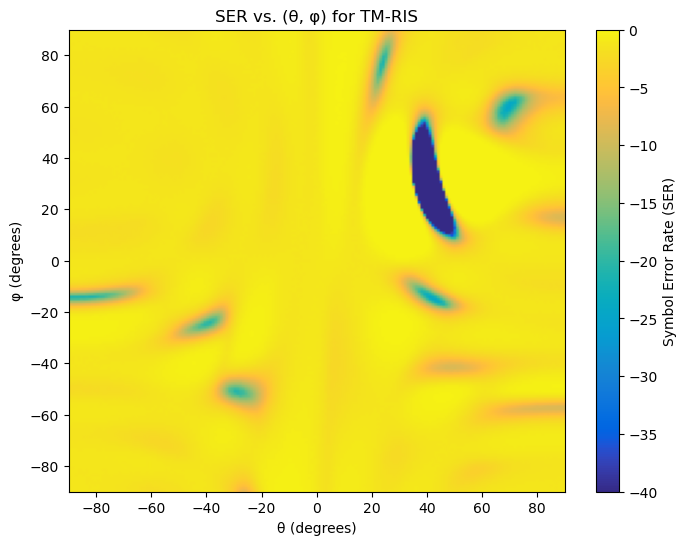

In [ ]:
###############################################################################
# Generate Time-Modulation Parameters based on the Rule-based method
###############################################################################
delta_tau = 0.7  # \Delta \tau_{mn} = 0.7 (since M_x*M_z >= K)
delta_tau_matrix = np.full((M_x, M_z), delta_tau)

# tau_{mn}^o comes from a random permutation of {0, 1/(M_x*M_z), 2/(M_x*M_z), ...}
M_total = M_x * M_z
perm    = rnd.permutation(M_total)

tau0_mat = np.zeros((M_x, M_z))
idx = 0
for m in range(M_x):
    for n in range(M_z):
        tau0_mat[m, n] = perm[idx] / M_total
        idx += 1

C_curr = compute_objective(tau0_mat, delta_tau_matrix)
print(C_curr)

print('\n')


# Grid for scanning directions (theta, phi)
theta_step = 1
phi_step   = 1
theta_list = np.arange(-90, 91, theta_step)  # theta amzimuth angle
phi_list   = np.arange(90, -91, -phi_step)     # phi elevation angle

theta_len = len(theta_list)
phi_len   = len(phi_list)

# Prepare a 2D array for SER results
SER_map = np.zeros((phi_len, theta_len))

print("Computing SER on a grid of size {} x {} ...".format(theta_len, phi_len))

# parallel process
SER_map = Parallel(n_jobs=-1)(   # use all available cores
    delayed(compute_SER)(th, ph, tau0_mat, delta_tau_matrix, Nsym=1024)
    for ph in phi_list
    for th in theta_list
)

# Then reshape SER_map to 2D
SER_map = np.array(SER_map).reshape(phi_len, theta_len)
SER_map = 10 * np.log10(SER_map + 1e-4)


# np.savez('results_data0.npz', best_tau0=tau0_mat, best_delta=delta_tau_matrix, SER_map=SER_map)

###############################################################################
# Plot the 2D Heatmap: SER vs. (theta, phi)
###############################################################################
plt.figure(figsize=(8, 6))

# By default, imshow will map array row 0 to the top. Our row 0 corresponds to theta=90 deg.
# We'll show phi along the x-axis, and theta along the y-axis (top=+90, bottom=-90).
# extent => [x_min, x_max, y_min, y_max], and we set origin='upper' to match indexing.
plt.imshow(
    SER_map,
    origin='upper',
    extent=[theta_list[0], theta_list[-1], phi_list[-1], phi_list[0]],
    aspect='auto',
    cmap=parula_map
)

plt.colorbar(label='Symbol Error Rate (SER)')
plt.title('SER vs. (θ, φ) for TM-RIS')
plt.xlabel('θ (degrees)')
plt.ylabel('φ (degrees)')
plt.show()




